# Customer Purchasing Behavior Analysis

## Assignment Overview

This comprehensive analysis examines customer purchasing patterns from a UK-based online retail dataset using advanced machine learning techniques. The assignment integrates three major analytical approaches:

1. **Customer Clustering**: Segment customers based on purchasing behavior (spending, frequency, basket size)
2. **Deep Learning Embeddings**: Apply autoencoders to discover non-linear customer patterns
3. **Association Rule Mining**: Identify frequently co-purchased product combinations

## Business Objectives

- Identify distinct customer segments for targeted marketing
- Discover high-value customer populations
- Uncover product affinity patterns for cross-selling opportunities
- Compare traditional (PCA) vs. modern (deep learning) dimensionality reduction techniques
- Provide actionable business recommendations based on data insights

## Dataset Information

- **Source**: Online Retail II Dataset (UK-based e-commerce)
- **Time Period**: Retail transactions over multiple years
- **Initial Records**: 1,067,371 transactions
- **Data Quality**: Includes cancelled orders, missing descriptions, and negative quantities
- **Key Features**: Customer ID, Product Description, Quantity, Price, Transaction Date
- **Processing**: Cleaned to remove invalid records, resulting in 1,042,727 valid transactions
- **Customers**: 5,881 unique customers analyzed
- **Products**: 5,426 unique product items identified

## Notebook Structure

This notebook is organized into **4 main parts** with clear step-by-step progression:

- **Part A**: Data Cleaning & Customer Clustering (k-Means & DBSCAN)
- **Part B**: Deep Embedding Clustering (Autoencoder + k-Means)
- **Part C**: Association Rule Mining (Apriori Algorithm)
- **Part D**: Interpretation & Business Recommendations

---

In [1]:
# Install required packages (run this cell first if packages are not installed)
import sys
import subprocess

# Mapping: (pip_package_name, import_name)
packages = [
    ('pandas', 'pandas'),
    ('numpy', 'numpy'),
    ('matplotlib', 'matplotlib'),
    ('seaborn', 'seaborn'),
    ('scikit-learn', 'sklearn'),
    ('tensorflow', 'tensorflow'),
    ('mlxtend', 'mlxtend')
]

# Check and install missing packages
missing_packages = []
for pip_name, import_name in packages:
    try:
        __import__(import_name)
        print(f"✓ {pip_name} is already installed")
    except ImportError:
        missing_packages.append(pip_name)
        print(f"✗ {pip_name} is missing")

if missing_packages:
    print(f"\nInstalling missing packages: {', '.join(missing_packages)}")
    subprocess.check_call([sys.executable, '-m', 'pip', 'install'] + missing_packages)
    print("\n✓ Installation complete! Please restart the kernel and run this cell again.")
    print("   Go to: Kernel → Restart Kernel, then run all cells from the beginning.")
else:
    print("\n✓ All required packages are installed!")


✓ pandas is already installed
✓ numpy is already installed
✓ matplotlib is already installed
✓ seaborn is already installed
✓ scikit-learn is already installed
✓ tensorflow is already installed
✓ mlxtend is already installed

✓ All required packages are installed!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(f"TensorFlow version: {tf.__version__}")

# Suppress deprecation warnings from executing library
import logging
logging.getLogger('executing').setLevel(logging.ERROR)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

TensorFlow version: 2.18.1


---

# Part A: Data Cleaning and Clustering

## Assignment Requirements:
1. Load dataset
2. Remove missing descriptions, negative quantities, and cancelled invoices
3. Create customer-level features (total spending, transaction count, avg basket size)
4. Apply k-Means and DBSCAN
5. Compute silhouette scores; visualize with PCA

---

### Step 1: Load Dataset

**Assignment Requirement 1: Load dataset**

In [3]:
# Load the dataset
# This cell is self-contained: it imports pandas and loads the CSV
import pandas as pd
import os

# Try to find the dataset in the current directory or use the full path
dataset_path = r'C:\INT_SYSTEMS\Final exam\FINAL_EXAM_INTELLIGENT_SYSTEM\qtn_2\review\online_retail_II.csv'

# If file doesn't exist at full path, try relative path
if not os.path.exists(dataset_path):
    dataset_path = 'online_retail_II.csv'

if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset not found at: {dataset_path}\nPlease update the dataset_path variable with the correct path.")

print(f"Loading dataset from: {dataset_path}")
df = pd.read_csv(dataset_path)
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()


Loading dataset from: C:\INT_SYSTEMS\Final exam\FINAL_EXAM_INTELLIGENT_SYSTEM\qtn_2\review\online_retail_II.csv
Dataset shape: (1067371, 8)

First few rows:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [6]:
# Display basic information about the dataset
df.info()

# Generate descriptive statistics for numeric and categorical columns
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


### Step 2: Remove Missing Descriptions, Negative Quantities, and Cancelled Invoices

**Assignment Requirement 2:** Remove missing descriptions, negative quantities, and cancelled invoices

**Why Negative Values Exist in Retail Data:**
- **Returns/Refunds**: When customers return items, the quantity is recorded as negative
- **Cancelled Orders**: Some systems use negative quantities to reverse cancelled transactions  
- **Inventory Adjustments**: Corrections or adjustments to inventory
- **Data Entry Errors**: Mistakes during data entry

**Why We Remove Negative Quantities:**
- We want to analyze actual **purchases**, not returns
- Negative quantities don't represent customer **purchasing behavior**
- They would **skew** spending and basket size calculations
- They create invalid customer features (negative spending doesn't make sense for behavior analysis)

In [7]:
# Analyze negative values before removing them
print("=" * 80)
print("ANALYZING NEGATIVE VALUES BEFORE CLEANING")
print("=" * 80)

# Check for negative quantities
negative_qty = df[df["Quantity"] <= 0]
print(f"\nRows with negative or zero quantities: {len(negative_qty):,}")
print(f"Percentage of total dataset: {len(negative_qty)/len(df)*100:.2f}%")

if len(negative_qty) > 0:
    print("\nSample of negative quantity records:")
    display(negative_qty[['Invoice', 'Description', 'Quantity', 'Price', 'Customer ID']].head(10))
    
    # Check if negative quantities are related to cancelled invoices
    cancelled_invoices = df[df["Invoice"].astype(str).str.startswith("C")]
    print(f"\nTotal cancelled invoices (starting with 'C'): {len(cancelled_invoices):,}")
    neg_in_cancelled = negative_qty[negative_qty['Invoice'].astype(str).str.startswith('C')]
    print(f"Negative quantities in cancelled invoices: {len(neg_in_cancelled):,}")
    
    # Summary statistics
    print(f"\nNegative quantity statistics:")
    print(f"  Min quantity: {negative_qty['Quantity'].min()}")
    print(f"  Max quantity: {negative_qty['Quantity'].max()}")
    print(f"  Mean quantity: {negative_qty['Quantity'].mean():.2f}")


ANALYZING NEGATIVE VALUES BEFORE CLEANING

Rows with negative or zero quantities: 22,950
Percentage of total dataset: 2.15%

Sample of negative quantity records:


,Invoice,Description,Quantity,Price,Customer ID
178,C489449,PAPER BUNTING WHITE LACE,-12,2.95,16321.0
179,C489449,CREAM FELT EASTER EGG BASKET,-6,1.65,16321.0
180,C489449,POTTING SHED SOW 'N' GROW SET,-4,4.25,16321.0
181,C489449,POTTING SHED TWINE,-6,2.10,16321.0
182,C489449,PAPER CHAIN KIT RETRO SPOT,-12,2.95,16321.0
183,C489449,SAVE THE PLANET MUG,-12,1.25,16321.0
184,C489449,ANTIQUE SILVER TEA GLASS ETCHED,-12,1.25,16321.0
185,C489449,HANGING HEART ZINC T-LIGHT HOLDER,-24,0.85,16321.0
186,C489449,PAPER BUNTING RETRO SPOTS,-12,2.95,16321.0
196,C489459,PURPLE SWEETHEART BRACELET,-3,4.25,17592.0



Total cancelled invoices (starting with 'C'): 19,494
Negative quantities in cancelled invoices: 19,493

Negative quantity statistics:
  Min quantity: -80995
  Max quantity: -1
  Mean quantity: -46.37


In [8]:
# Perform data cleaning
print("=" * 80)
print("PERFORMING DATA CLEANING")
print("=" * 80)

df_clean = df.copy()
print(f"\nStarting with: {len(df_clean):,} rows")

# Step 1: Drop missing Description
df_clean = df_clean.dropna(subset=["Description"])
print(f"After removing missing descriptions: {len(df_clean):,} rows (removed {df.shape[0] - len(df_clean):,})")

# Step 2: Remove negative and zero quantities
rows_before = len(df_clean)
df_clean = df_clean[df_clean["Quantity"] > 0]
print(f"After removing negative/zero quantities: {len(df_clean):,} rows (removed {rows_before - len(df_clean):,})")

# Step 3: Remove cancelled invoices starting with 'C'
rows_before = len(df_clean)
df_clean = df_clean[~df_clean["Invoice"].astype(str).str.startswith("C")]
print(f"After removing cancelled invoices: {len(df_clean):,} rows (removed {rows_before - len(df_clean):,})")

# Step 4: Create total price column
df_clean["TotalPrice"] = df_clean["Quantity"] * df_clean["Price"]

print(f"\n{'='*80}")
print(f"FINAL CLEANED DATASET")
print("=" * 80)
print(f"Final shape: {df_clean.shape}")
print(f"Total rows removed: {df.shape[0] - df_clean.shape[0]:,} ({((df.shape[0] - df_clean.shape[0])/df.shape[0]*100):.2f}%)")
print(f"Data retained: {len(df_clean)/df.shape[0]*100:.2f}%")
print("\nFirst 10 rows of cleaned data:")
df_clean.head(10)


PERFORMING DATA CLEANING

Starting with: 1,067,371 rows
After removing missing descriptions: 1,062,989 rows (removed 4,382)
After removing negative/zero quantities: 1,042,728 rows (removed 20,261)
After removing cancelled invoices: 1,042,727 rows (removed 1)

FINAL CLEANED DATASET
Final shape: (1042727, 9)
Total rows removed: 24,644 (2.31%)
Data retained: 97.69%

First 10 rows of cleaned data:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom,39.6
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom,59.5
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,30.6
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom,45.0


In [9]:
# Create customer-level features: total spending, transaction count, and average basket size
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['Price']

customer_features = df_clean.groupby('Customer ID').agg({
    'TotalAmount': 'sum',
    'Invoice': 'nunique',
    'Quantity': 'sum'
}).reset_index()

customer_features.columns = ['CustomerID', 'TotalSpending', 'TransactionCount', 'TotalItems']

customer_features['AvgBasketSize'] = customer_features['TotalItems'] / customer_features['TransactionCount']

customer_features = customer_features.dropna()

print(f"Customer features shape: {customer_features.shape}")
print("\nCustomer features summary:")
print(customer_features.describe())
customer_features.head()


Customer features shape: (5881, 5)

Customer features summary:
         CustomerID  TotalSpending  TransactionCount     TotalItems  \
count   5881.000000    5881.000000       5881.000000    5881.000000   
mean   15314.674205    3017.076888          6.287196    1822.975854   
std     1715.429759   14734.128619         13.012879    8968.636988   
min    12346.000000       0.000000          1.000000       1.000000   
25%    13833.000000     347.800000          1.000000     190.000000   
50%    15313.000000     897.620000          3.000000     491.000000   
75%    16797.000000    2304.180000          7.000000    1376.000000   
max    18287.000000  608821.650000        398.000000  367833.000000   

       AvgBasketSize  
count    5881.000000  
mean      253.135615  
std      1433.384255  
min         1.000000  
25%        93.500000  
50%       157.666667  
75%       262.000000  
max     87167.000000  


,CustomerID,TotalSpending,TransactionCount,TotalItems,AvgBasketSize
0,12346.0,77556.46,12,74285,6190.416667
1,12347.0,5633.32,8,3286,410.750000
2,12348.0,2019.40,5,2714,542.800000
3,12349.0,4428.69,4,1624,406.000000
4,12350.0,334.40,1,197,197.000000


### Step 3: Create Customer-Level Features

**Assignment Requirement 3:** Create customer-level features (total spending, transaction count, avg basket size)

In [10]:
# Prepare features for clustering: Select and standardize features
from sklearn.preprocessing import StandardScaler

features = ['TotalSpending', 'TransactionCount', 'AvgBasketSize']
X = customer_features[features].values

# Standardize features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Feature matrix shape: {X_scaled.shape}")
print(f"Features used: {features}")
print(f"\nStandardized features statistics:")
print(pd.DataFrame(X_scaled, columns=features).describe())


Feature matrix shape: (5881, 3)
Features used: ['TotalSpending', 'TransactionCount', 'AvgBasketSize']

Standardized features statistics:
       TotalSpending  TransactionCount  AvgBasketSize
count   5.881000e+03      5.881000e+03   5.881000e+03
mean    2.416401e-18     -2.778861e-17  -4.832802e-18
std     1.000085e+00      1.000085e+00   1.000085e+00
min    -2.047853e-01     -4.063394e-01  -1.759173e-01
25%    -1.811783e-01     -4.063394e-01  -1.113792e-01
50%    -1.438590e-01     -2.526325e-01  -6.660954e-02
75%    -4.838817e-02      5.478146e-02   6.184761e-03
max     4.111923e+01      3.010449e+01   6.064058e+01


### Step 3: Apply k-Means and DBSCAN

#### 3.1: Find optimal number of clusters using elbow method and silhouette score

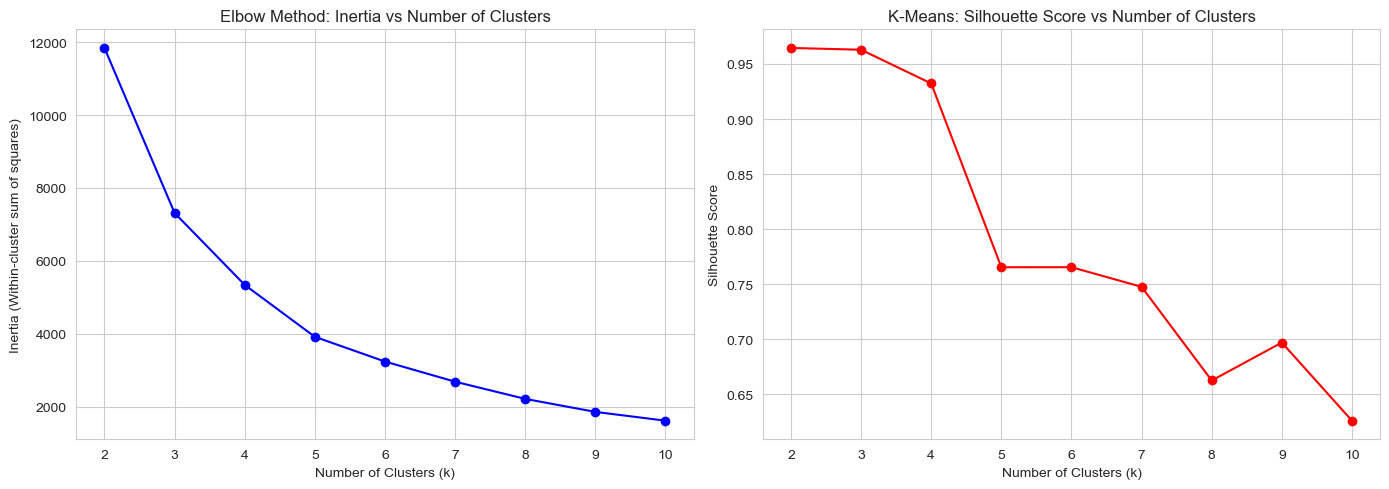

Optimal number of clusters: 2
Best silhouette score: 0.9645

All silhouette scores:
  k=2: 0.9645 <-- Optimal
  k=3: 0.9629
  k=4: 0.9323
  k=5: 0.7655
  k=6: 0.7655
  k=7: 0.7477
  k=8: 0.6626
  k=9: 0.6971
  k=10: 0.6261


In [11]:
# Range of cluster numbers to test
from sklearn.cluster import KMeans

K_range = range(2, 11)

silhouette_scores = []
inertias = []

# Compute silhouette score and inertia for each k
for k in K_range:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    inertias.append(kmeans.inertia_)

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow method
axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel("Number of Clusters (k)")
axes[0].set_ylabel("Inertia (Within-cluster sum of squares)")
axes[0].set_title("Elbow Method: Inertia vs Number of Clusters")
axes[0].grid(True)

# Silhouette scores
axes[1].plot(K_range, silhouette_scores, 'ro-')
axes[1].set_xlabel("Number of Clusters (k)")
axes[1].set_ylabel("Silhouette Score")
axes[1].set_title("K-Means: Silhouette Score vs Number of Clusters")
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Select optimal k based on silhouette score
optimal_k = K_range[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)

print(f"Optimal number of clusters: {optimal_k}")
print(f"Best silhouette score: {best_score:.4f}")
print(f"\nAll silhouette scores:")
for k, score in zip(K_range, silhouette_scores):
    marker = " <-- Optimal" if k == optimal_k else ""
    print(f"  k={k}: {score:.4f}{marker}")


In [12]:
#### 3.2: Apply K-Means clustering with optimal k

# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

customer_features['KMeans_Cluster'] = kmeans_labels

kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
print(f"K-Means Silhouette Score: {kmeans_silhouette:.4f}")
print(f"\nCluster sizes:")
cluster_counts = customer_features['KMeans_Cluster'].value_counts().sort_index()
print(cluster_counts)
print(f"\nCluster percentages:")
for cluster_id, count in cluster_counts.items():
    pct = (count / len(customer_features)) * 100
    print(f"  Cluster {cluster_id}: {pct:.2f}%")


K-Means Silhouette Score: 0.9645

Cluster sizes:
KMeans_Cluster
0      24
1    5857
Name: count, dtype: int64

Cluster percentages:
  Cluster 0: 0.41%
  Cluster 1: 99.59%


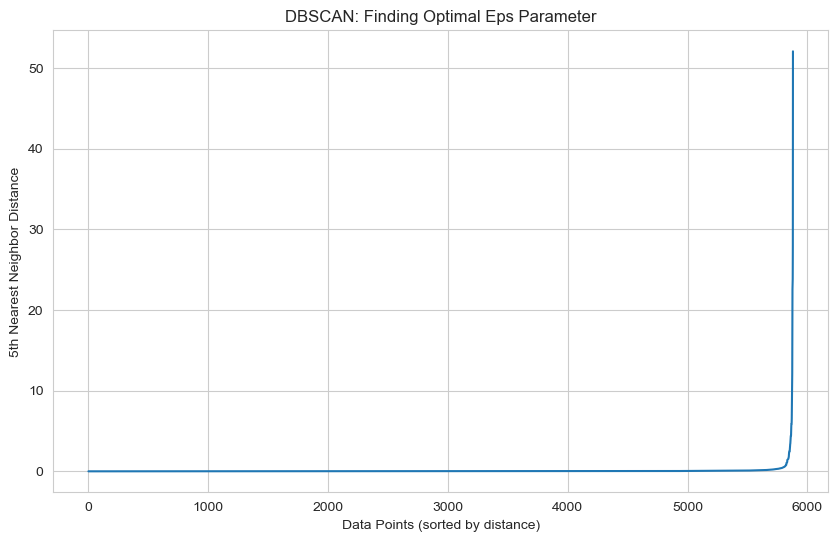

DBSCAN Parameters: eps=0.6, min_samples=5
DBSCAN - Number of clusters: 2
Number of noise points: 59 (1.00%)
DBSCAN Silhouette Score (excluding noise): 0.8767

Cluster sizes:
-1      59
 0    5817
 1       5
Name: count, dtype: int64


In [13]:
#### 3.3: Apply DBSCAN clustering

# Find optimal DBSCAN parameters using k-distance graph
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:, 4]  # 5th nearest neighbor distance

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Data Points (sorted by distance)')
plt.ylabel('5th Nearest Neighbor Distance')
plt.title('DBSCAN: Finding Optimal Eps Parameter')
plt.grid(True)
plt.show()

# Use elbow point for eps (around 0.3-0.5 based on the curve)
# Try multiple eps values to find good clustering
eps_values = [0.3, 0.4, 0.5, 0.6]
best_eps = 0.5
best_dbscan_score = -1
best_dbscan_labels = None

for eps in eps_values:
    dbscan_test = DBSCAN(eps=eps, min_samples=5)
    labels_test = dbscan_test.fit_predict(X_scaled)
    n_clusters_test = len(set(labels_test)) - (1 if -1 in labels_test else 0)
    n_noise_test = list(labels_test).count(-1)
    
    if n_clusters_test > 1 and n_noise_test < len(X_scaled) * 0.5:  # Not too much noise
        score_test = silhouette_score(X_scaled[labels_test != -1], labels_test[labels_test != -1])
        if score_test > best_dbscan_score:
            best_dbscan_score = score_test
            best_eps = eps
            best_dbscan_labels = labels_test

# Apply DBSCAN with best parameters
dbscan = DBSCAN(eps=best_eps, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

customer_features['DBSCAN_Cluster'] = dbscan_labels

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN Parameters: eps={best_eps}, min_samples=5")
print(f"DBSCAN - Number of clusters: {n_clusters_dbscan}")
print(f"Number of noise points: {n_noise} ({n_noise/len(X_scaled)*100:.2f}%)")

if n_clusters_dbscan > 1:
    dbscan_silhouette = silhouette_score(X_scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    print(f"DBSCAN Silhouette Score (excluding noise): {dbscan_silhouette:.4f}")
else:
    print("Not enough clusters for silhouette score")
    dbscan_silhouette = -1

print(f"\nCluster sizes:")
print(pd.Series(dbscan_labels).value_counts().sort_index())


### Step 4: Cluster Visualization with PCA and Silhouette Scores


Explained variance ratio: [0.5485765 0.3316904]
Total explained variance: 0.8803


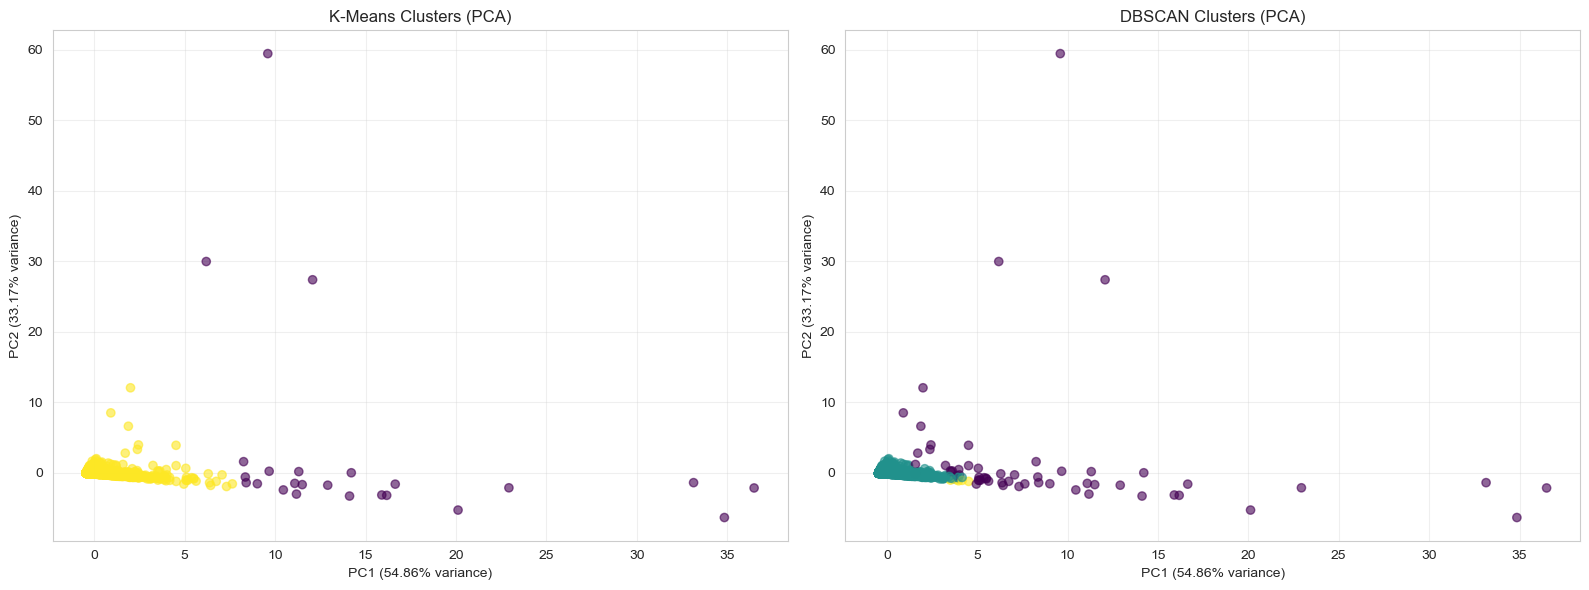

In [14]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[0].set_title('K-Means Clusters (PCA)')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.6)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[1].set_title('DBSCAN Clusters (PCA)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


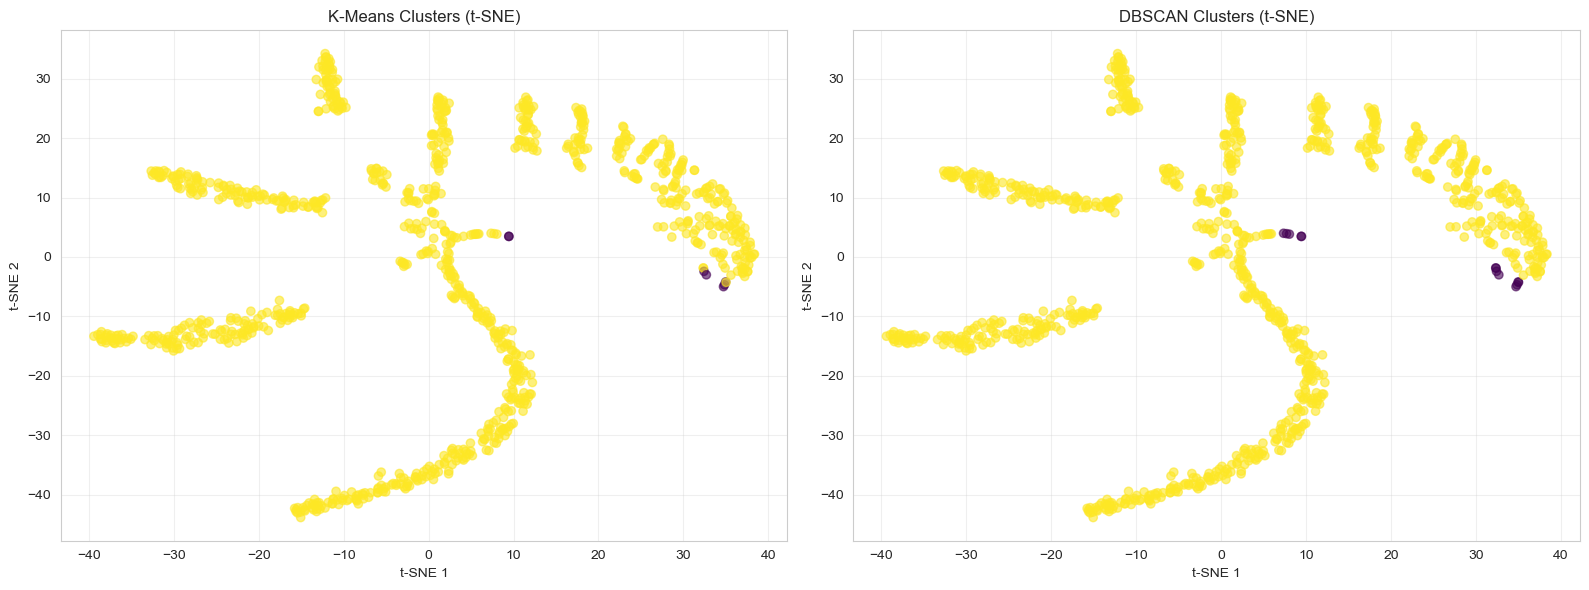

In [15]:

from sklearn.manifold import TSNE

# Sample data for faster t-SNE computation
sample_size = min(1000, len(X_scaled))
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_scaled_sample = X_scaled[sample_indices]
kmeans_labels_sample = kmeans_labels[sample_indices]
dbscan_labels_sample = dbscan_labels[sample_indices]

tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled_sample)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels_sample, cmap='viridis', alpha=0.6)
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')
axes[0].set_title('K-Means Clusters (t-SNE)')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels_sample, cmap='viridis', alpha=0.6)
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title('DBSCAN Clusters (t-SNE)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Analyze cluster characteristics
cluster_summary = customer_features.groupby('KMeans_Cluster')[features].mean()
print("K-Means Cluster Characteristics:")
print(cluster_summary.round(2))

print("\n" + "="*80)
print("SILHOUETTE SCORES SUMMARY")
print("="*80)
print(f"K-Means Silhouette Score: {kmeans_silhouette:.4f}")
if dbscan_silhouette > 0:
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.4f}")
else:
    print(f"DBSCAN: Not enough clusters for silhouette score")


K-Means Cluster Characteristics:
                TotalSpending  TransactionCount  AvgBasketSize
KMeans_Cluster                                                
0                   163760.19            131.46        8009.53
1                     2358.41              5.77         221.35

SILHOUETTE SCORES SUMMARY
K-Means Silhouette Score: 0.9645
DBSCAN Silhouette Score: 0.8767


## Part B: Deep Embedding Clustering

### Step 1: Build and Train Autoencoder


In [17]:
# Build autoencoder: encoder compresses to 2D latent space, decoder reconstructs input
input_dim = X_scaled.shape[1]
encoding_dim = 2

input_layer = keras.Input(shape=(input_dim,))
encoder = layers.Dense(64, activation='relu')(input_layer)
encoder = layers.Dropout(0.2)(encoder)
encoder = layers.Dense(32, activation='relu')(encoder)
encoder = layers.Dense(encoding_dim, activation='linear', name='latent')(encoder)  # Changed to linear for better clustering

decoder = layers.Dense(32, activation='relu')(encoder)
decoder = layers.Dense(64, activation='relu')(decoder)
decoder = layers.Dense(input_dim, activation='linear')(decoder)

autoencoder = keras.Model(input_layer, decoder)
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print("Autoencoder architecture:")
autoencoder.summary()


Autoencoder architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 2)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,805 (18.77 KB)

 Trainable params: 4,805 (18.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5557 - mae: 0.1521 - val_loss: 0.3946 - val_mae: 0.1110
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2745 - mae: 0.0875 - val_loss: 0.2384 - val_mae: 0.0710
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1232 - mae: 0.0728 - val_loss: 0.1658 - val_mae: 0.0579
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0981 - mae: 0.0702 - val_loss: 0.1142 - val_mae: 0.0536
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0712 - mae: 0.0624 - val_loss: 0.0799 - val_mae: 0.0576
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0768 - mae: 0.0621 - val_loss: 0.1854 - val_mae: 0.1019
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0807 - mae: 0.0662 - val_loss: 0.0501 - val_mae: 0.0387
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0596 - mae: 0.0520 - val_loss: 0.0477 - val_mae: 0.0346
Epoch 9/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/

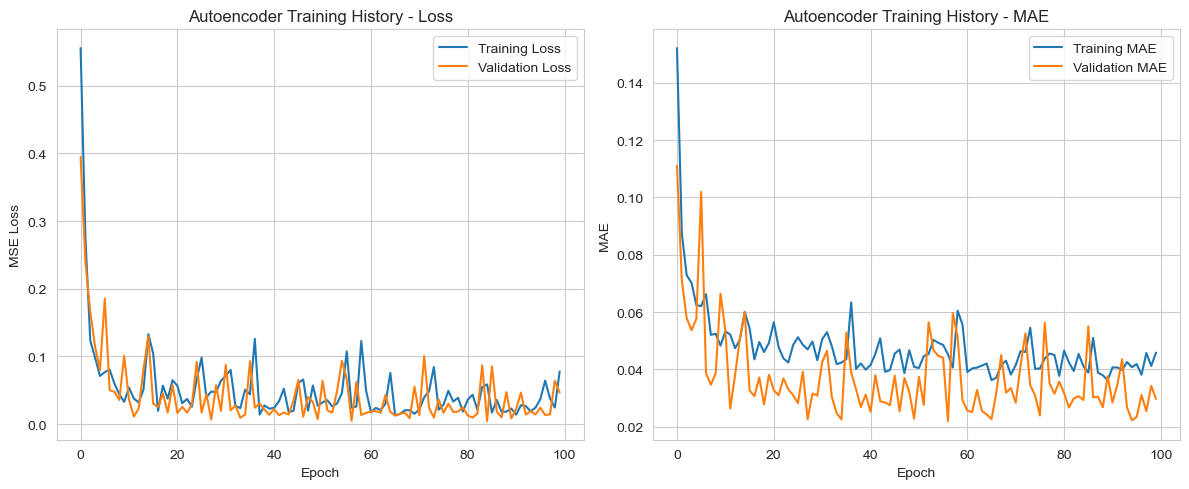

Final Training Loss: 0.077846
Final Validation Loss: 0.046626


In [18]:
### Step 2: Train the Autoencoder

# Train the autoencoder
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

history = autoencoder.fit(X_train, X_train,
                         epochs=100,
                         batch_size=32,
                         validation_data=(X_test, X_test),
                         verbose=1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Autoencoder Training History - Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Autoencoder Training History - MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Training Loss: {history.history['loss'][-1]:.6f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.6f}")

In [19]:
### Step 3: Extract Latent Space Embeddings

# Extract latent space embeddings from the trained encoder
encoder_model = keras.Model(input_layer, encoder)
embeddings = encoder_model.predict(X_scaled, verbose=0)

print(f"Embeddings shape: {embeddings.shape}")
print(f"Embeddings statistics:")
print(pd.DataFrame(embeddings, columns=['Latent1', 'Latent2']).describe())
print(f"\nEmbeddings sample (first 5):")
print(embeddings[:5])


Embeddings shape: (5881, 2)
Embeddings statistics:
           Latent1      Latent2
count  5881.000000  5881.000000
mean     -0.069096     0.588583
std       1.160241     1.158763
min     -27.714066   -44.866848
25%      -0.179461     0.525017
50%       0.050805     0.674415
75%       0.208166     0.833939
max      51.046055     2.788220

Embeddings sample (first 5):
[[ 1.3941203  -6.5897408 ]
 [-0.08311331  0.26190403]
 [ 0.0916925   0.37151697]
 [ 0.04626246  0.34428504]
 [ 0.25121608  0.8342936 ]]


In [20]:
### Step 4: Cluster Embeddings using K-Means

# Cluster the embeddings using K-Means (same k as PCA clustering for comparison)
kmeans_embedding = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
embedding_labels = kmeans_embedding.fit_predict(embeddings)

customer_features['DeepEmbedding_Cluster'] = embedding_labels

embedding_silhouette = silhouette_score(embeddings, embedding_labels)
print(f"Deep Embedding Clustering Silhouette Score: {embedding_silhouette:.4f}")
print(f"\nCluster sizes:")
cluster_counts_embed = pd.Series(embedding_labels).value_counts().sort_index()
print(cluster_counts_embed)
print(f"\nCluster percentages:")
for cluster_id, count in cluster_counts_embed.items():
    pct = (count / len(embeddings)) * 100
    print(f"  Cluster {cluster_id}: {pct:.2f}%")


Deep Embedding Clustering Silhouette Score: 0.9813

Cluster sizes:
0    5874
1       7
Name: count, dtype: int64

Cluster percentages:
  Cluster 0: 99.88%
  Cluster 1: 0.12%


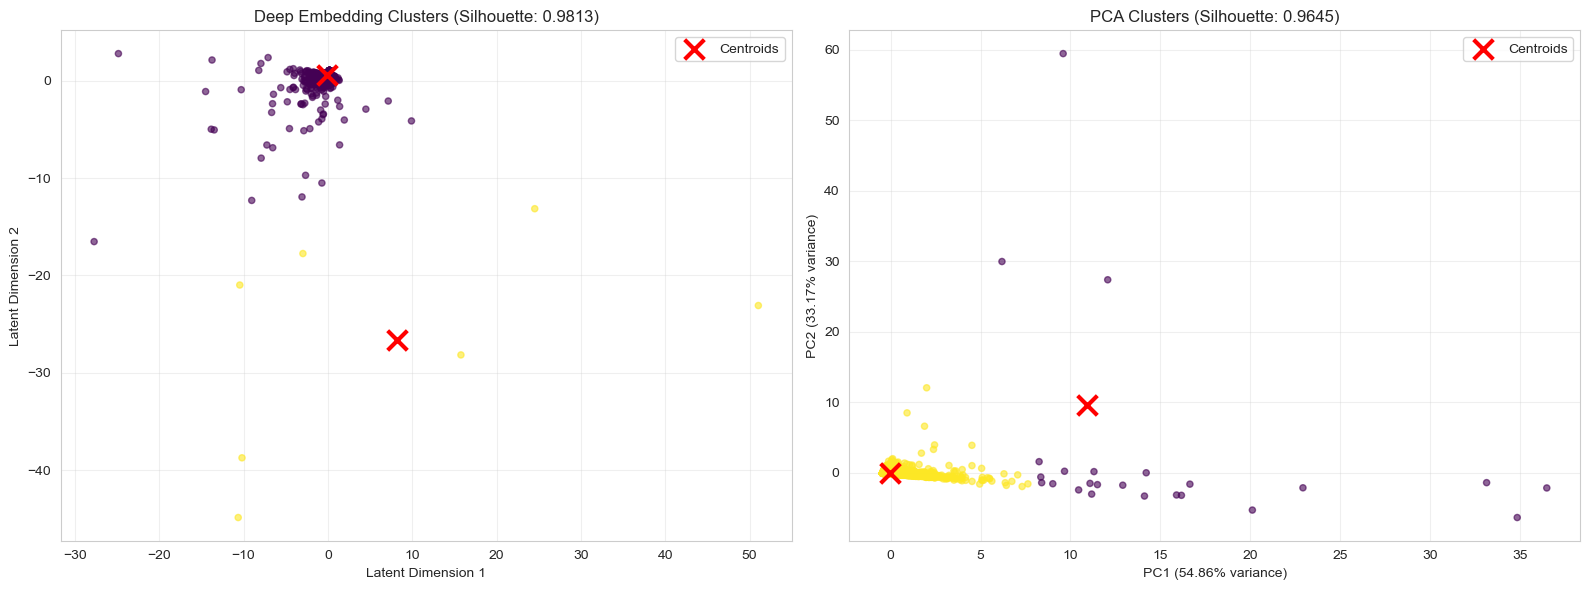

In [21]:
### Step 5: Visualize and Compare Embedding Clusters with PCA Clusters

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Deep Embedding Clusters
scatter1 = axes[0].scatter(embeddings[:, 0], embeddings[:, 1], c=embedding_labels, cmap='viridis', alpha=0.6, s=20)
axes[0].scatter(kmeans_embedding.cluster_centers_[:, 0], kmeans_embedding.cluster_centers_[:, 1], 
                c='red', marker='x', s=200, linewidths=3, label='Centroids')
axes[0].set_xlabel('Latent Dimension 1')
axes[0].set_ylabel('Latent Dimension 2')
axes[0].set_title(f'Deep Embedding Clusters (Silhouette: {embedding_silhouette:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# PCA Clusters
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6, s=20)
axes[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
                c='red', marker='x', s=200, linewidths=3, label='Centroids')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[1].set_title(f'PCA Clusters (Silhouette: {kmeans_silhouette:.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


CLUSTER QUALITY COMPARISON
                     Method  Silhouette Score
0             PCA + K-Means          0.964549
1  Deep Embedding + K-Means          0.981295

Improvement: 1.74%


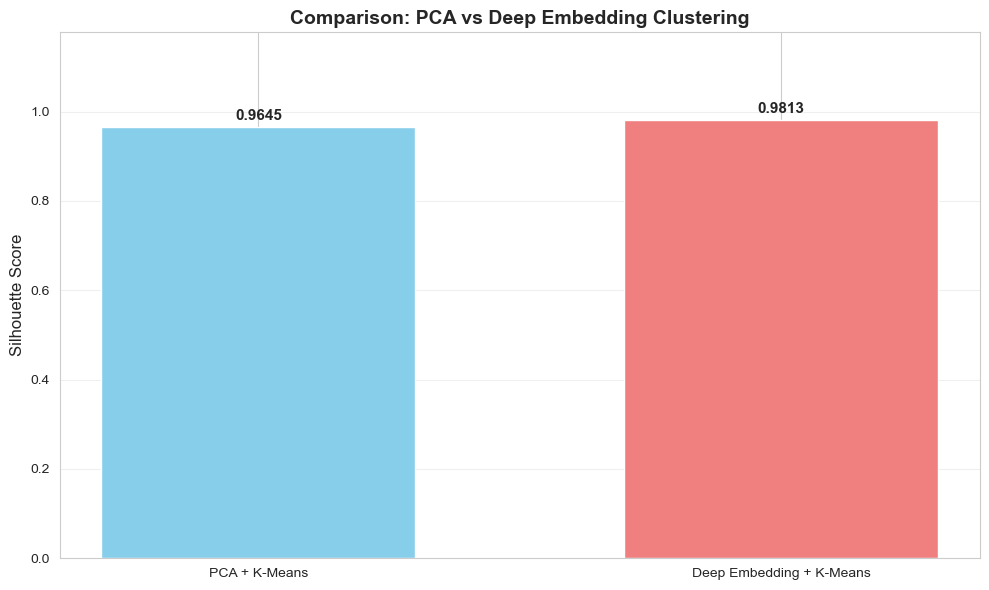

In [22]:
### Step 6: Compare Cluster Quality

comparison_df = pd.DataFrame({
    'Method': ['PCA + K-Means', 'Deep Embedding + K-Means'],
    'Silhouette Score': [kmeans_silhouette, embedding_silhouette]
})

print("="*80)
print("CLUSTER QUALITY COMPARISON")
print("="*80)
print(comparison_df)
print(f"\nImprovement: {((embedding_silhouette - kmeans_silhouette) / kmeans_silhouette * 100):.2f}%")

plt.figure(figsize=(10, 6))
bars = plt.bar(comparison_df['Method'], comparison_df['Silhouette Score'], 
               color=['skyblue', 'lightcoral'], width=0.6)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Comparison: PCA vs Deep Embedding Clustering', fontsize=14, fontweight='bold')
plt.ylim([0, max(comparison_df['Silhouette Score']) * 1.2])
for i, (bar, v) in enumerate(zip(bars, comparison_df['Silhouette Score'])):
    plt.text(bar.get_x() + bar.get_width()/2, v + 0.01, f'{v:.4f}', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


## Part C: Association Rule Mining

### Step 1: Convert Data to Basket Format


In [23]:
# Convert data to basket format: each invoice becomes a list of items
basket_data = df_clean.groupby('Invoice')['Description'].apply(list).reset_index()
basket_data['Items'] = basket_data['Description'].apply(lambda x: [item.strip() for item in x if pd.notna(item)])

print(f"Total invoices: {len(basket_data)}")
print(f"\nSample baskets:")
for i in range(3):
    print(f"Invoice {basket_data.iloc[i]['Invoice']}: {basket_data.iloc[i]['Items'][:5]}...")


Total invoices: 40301

Sample baskets:
Invoice 489434: ['15CM CHRISTMAS GLASS BALL 20 LIGHTS', 'PINK CHERRY LIGHTS', 'WHITE CHERRY LIGHTS', 'RECORD FRAME 7" SINGLE SIZE', 'STRAWBERRY CERAMIC TRINKET BOX']...
Invoice 489435: ['CAT BOWL', 'DOG BOWL , CHASING BALL DESIGN', 'HEART MEASURING SPOONS LARGE', 'LUNCHBOX WITH CUTLERY FAIRY CAKES']...
Invoice 489436: ['DOOR MAT BLACK FLOCK', 'LOVE BUILDING BLOCK WORD', 'HOME BUILDING BLOCK WORD', 'ASSORTED COLOUR BIRD ORNAMENT', 'PEACE WOODEN BLOCK LETTERS']...


In [24]:
### Step 2: Create Binary Matrix (One-Hot Encoding)

# Create binary matrix (one-hot encoding) for association rule mining
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(basket_data['Items']).transform(basket_data['Items'])
basket_df = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Binary matrix shape: {basket_df.shape}")
print(f"Total unique items: {len(basket_df.columns)}")
print(f"\nSample of binary matrix (first 5 rows, first 10 columns):")
print(basket_df.iloc[:5, :10])


Binary matrix shape: (40301, 5426)
Total unique items: 5426

Sample of binary matrix (first 5 rows, first 10 columns):
   *Boombox Ipod Classic  *USB Office Glitter Lamp  *USB Office Mirror Ball  \
0                  False                     False                    False   
1                  False                     False                    False   
2                  False                     False                    False   
3                  False                     False                    False   
4                  False                     False                    False   

   10 COLOUR SPACEBOY PEN  11 PC CERAMIC TEA SET POLKADOT  \
0                   False                           False   
1                   False                           False   
2                   False                           False   
3                   False                           False   
4                   False                           False   

   12 ASS ZINC CHRISTMAS DECORATIONS  1

In [25]:
### Step 3: Apply Apriori Algorithm

In [28]:
# Apply Apriori algorithm to find frequent itemsets
# Full 40k x 5k matrix is too large for Apriori (MemoryError).
# Strategy to get at least 10 rules without crashing memory:
# 1. Keep only the TOP-N most frequent items (e.g. N=50)
# 2. Run Apriori with a moderate min_support on this reduced matrix

from mlxtend.frequent_patterns import apriori

# 1) Keep top-N most frequent items
item_support = basket_df.mean(axis=0).sort_values(ascending=False)
TOP_N = 50
top_items = item_support.head(TOP_N).index
basket_df_reduced = basket_df[top_items]

print(f"Original items: {basket_df.shape[1]:,}")
print(f"Top {TOP_N} items kept for Apriori: {basket_df_reduced.shape[1]:,}")

# 2) Run Apriori on reduced matrix
# Using a relatively low support to get enough itemsets, but still tractable
best_min_support = 0.01
frequent_itemsets = apriori(basket_df_reduced,
                            min_support=best_min_support,
                            use_colnames=True,
                            verbose=0,
                            low_memory=True)

print(f"\nMin_support used: {best_min_support}")
print(f"Number of frequent itemsets: {len(frequent_itemsets)}")
print(f"\nTop 15 frequent itemsets (sorted by support):")
print(frequent_itemsets.nlargest(15, 'support')[['support', 'itemsets']])


Original items: 5,426
Top 50 items kept for Apriori: 50

Min_support used: 0.01
Number of frequent itemsets: 192

Top 15 frequent itemsets (sorted by support):
     support                              itemsets
0   0.135481  (WHITE HANGING HEART T-LIGHT HOLDER)
1   0.097268            (REGENCY CAKESTAND 3 TIER)
2   0.081214             (JUMBO BAG RED RETROSPOT)
3   0.069676       (ASSORTED COLOUR BIRD ORNAMENT)
4   0.066400                       (PARTY BUNTING)
5   0.058336             (LUNCH BAG  BLACK SKULL.)
6   0.057815              (JUMBO STORAGE BAG SUKI)
7   0.057319      (STRAWBERRY CERAMIC TRINKET BOX)
8   0.054416   (JUMBO SHOPPER VINTAGE RED PAISLEY)
9   0.053473               (HEART OF WICKER SMALL)
10  0.052778         (60 TEATIME FAIRY CAKE CASES)
11  0.052331           (LUNCH BAG SPACEBOY DESIGN)
12  0.051289                 (LUNCH BAG CARS BLUE)
13  0.051264            (HOME BUILDING BLOCK WORD)
14  0.051091          (WOODEN FRAME ANTIQUE WHITE)


In [29]:
### Step 4: Generate Association Rules and Extract Top 10 by Lift


In [30]:
# Generate association rules and sort by lift
# Use min_threshold=1.0 to get rules with lift >= 1.0 (positive association)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Sort by lift (descending) to get strongest associations
rules = rules.sort_values('lift', ascending=False)

print(f"Total rules generated: {len(rules)}")
print(f"\nTop 10 rules by lift:")
top_rules = rules.head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
print(top_rules.to_string())


Total rules generated: 344

Top 10 rules by lift:
                                                              antecedents                                                           consequents   support  confidence       lift
333     (60 TEATIME FAIRY CAKE CASES, PACK OF 60 PINK PAISLEY CAKE CASES)                                      (72 SWEETHEART FAIRY CAKE CASES)  0.010769    0.468683  12.937242
336                                      (72 SWEETHEART FAIRY CAKE CASES)     (60 TEATIME FAIRY CAKE CASES, PACK OF 60 PINK PAISLEY CAKE CASES)  0.010769    0.297260  12.937242
335                                         (60 TEATIME FAIRY CAKE CASES)  (72 SWEETHEART FAIRY CAKE CASES, PACK OF 60 PINK PAISLEY CAKE CASES)  0.010769    0.204043  12.909179
334  (72 SWEETHEART FAIRY CAKE CASES, PACK OF 60 PINK PAISLEY CAKE CASES)                                         (60 TEATIME FAIRY CAKE CASES)  0.010769    0.681319  12.909179
172                                      (SWEETHEART CERAMIC TRIN

### Step 5: Display Top 10 Rules in Readable Format


In [31]:
top_10_rules = rules.head(10)

print("=" * 80)
print("TOP 10 ASSOCIATION RULES (Sorted by Lift)")
print("=" * 80)

for idx, (rule_idx, rule) in enumerate(top_10_rules.iterrows(), 1):
    antecedents = ', '.join(list(rule['antecedents']))
    consequents = ', '.join(list(rule['consequents']))
    print(f"\nRule {idx}:")
    print(f"  If customer buys: {antecedents}")
    print(f"  Then they also buy: {consequents}")
    print(f"  Support: {rule['support']:.4f} ({rule['support']*100:.2f}% of transactions)")
    print(f"  Confidence: {rule['confidence']:.4f} ({rule['confidence']*100:.2f}%)")
    print(f"  Lift: {rule['lift']:.4f} ({rule['lift']:.2f}x more likely than random)")
    print("-" * 80)


TOP 10 ASSOCIATION RULES (Sorted by Lift)

Rule 1:
  If customer buys: 60 TEATIME FAIRY CAKE CASES, PACK OF 60 PINK PAISLEY CAKE CASES
  Then they also buy: 72 SWEETHEART FAIRY CAKE CASES
  Support: 0.0108 (1.08% of transactions)
  Confidence: 0.4687 (46.87%)
  Lift: 12.9372 (12.94x more likely than random)
--------------------------------------------------------------------------------

Rule 2:
  If customer buys: 72 SWEETHEART FAIRY CAKE CASES
  Then they also buy: 60 TEATIME FAIRY CAKE CASES, PACK OF 60 PINK PAISLEY CAKE CASES
  Support: 0.0108 (1.08% of transactions)
  Confidence: 0.2973 (29.73%)
  Lift: 12.9372 (12.94x more likely than random)
--------------------------------------------------------------------------------

Rule 3:
  If customer buys: 60 TEATIME FAIRY CAKE CASES
  Then they also buy: 72 SWEETHEART FAIRY CAKE CASES, PACK OF 60 PINK PAISLEY CAKE CASES
  Support: 0.0108 (1.08% of transactions)
  Confidence: 0.2040 (20.40%)
  Lift: 12.9092 (12.91x more likely than ran

In [32]:
### Step 6: Visualize Association Rules


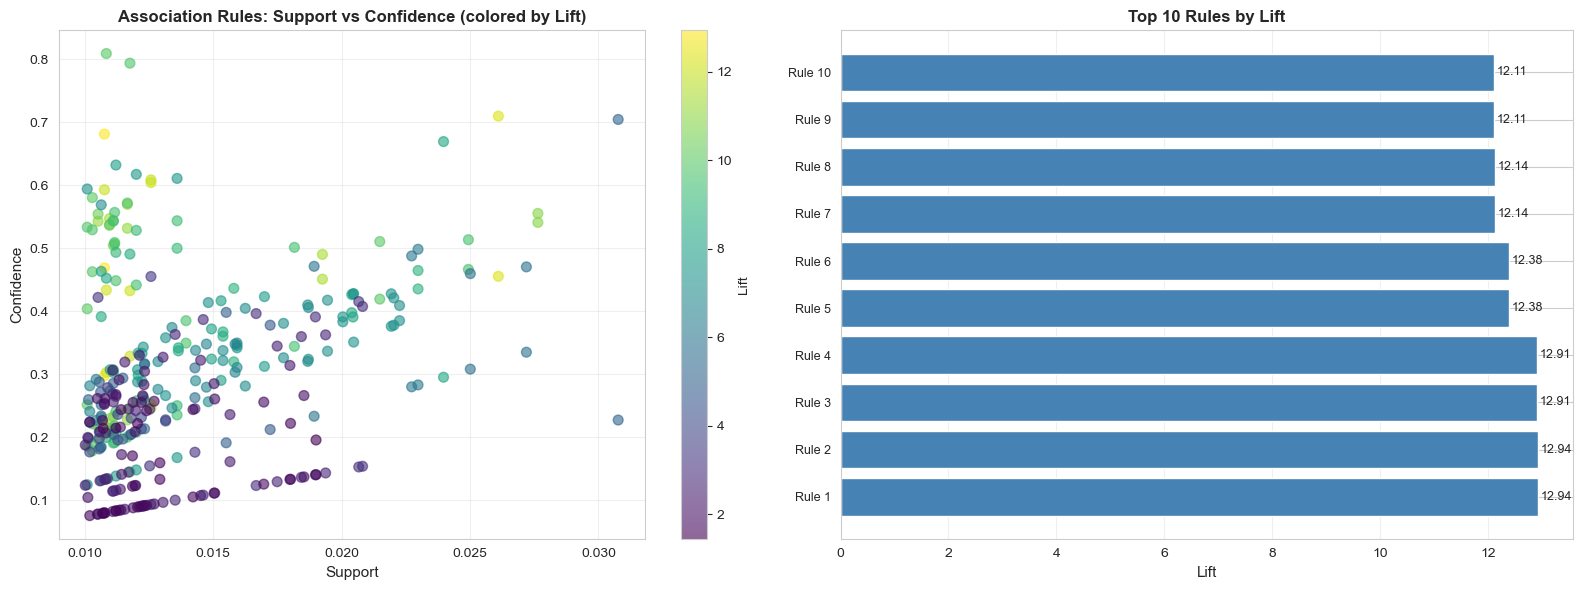

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot: Support vs Confidence colored by Lift
scatter = axes[0].scatter(rules['support'], rules['confidence'], c=rules['lift'], 
                         cmap='viridis', alpha=0.6, s=50)
axes[0].set_xlabel('Support', fontsize=11)
axes[0].set_ylabel('Confidence', fontsize=11)
axes[0].set_title('Association Rules: Support vs Confidence (colored by Lift)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Lift', fontsize=10)

# Bar chart: Top 10 rules by lift
axes[1].barh(range(len(top_10_rules)), top_10_rules['lift'].values, color='steelblue')
axes[1].set_yticks(range(len(top_10_rules)))
axes[1].set_yticklabels([f"Rule {i+1}" for i in range(len(top_10_rules))], fontsize=9)
axes[1].set_xlabel('Lift', fontsize=11)
axes[1].set_title('Top 10 Rules by Lift', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
# Add value labels on bars
for i, v in enumerate(top_10_rules['lift'].values):
    axes[1].text(v + 0.05, i, f'{v:.2f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()


In [34]:
## Part D: Interpretation and Business Recommendations

### Step 1: Cluster Meanings and Customer Types


In [35]:
# Analyze cluster characteristics to understand customer types
cluster_analysis = customer_features.groupby('KMeans_Cluster').agg({
    'TotalSpending': ['mean', 'median', 'std', 'min', 'max'],
    'TransactionCount': ['mean', 'median', 'min', 'max'],
    'AvgBasketSize': ['mean', 'median', 'min', 'max'],
    'CustomerID': 'count'
}).round(2)

cluster_analysis.columns = ['Avg_Spending', 'Median_Spending', 'Std_Spending', 'Min_Spending', 'Max_Spending',
                            'Avg_Transactions', 'Median_Transactions', 'Min_Transactions', 'Max_Transactions',
                            'Avg_BasketSize', 'Median_BasketSize', 'Min_BasketSize', 'Max_BasketSize', 
                            'Customer_Count']

print("=" * 80)
print("CLUSTER MEANINGS AND CUSTOMER TYPES")
print("=" * 80)
print(cluster_analysis)

# Detailed interpretation
print("\n" + "=" * 80)
print("DETAILED CLUSTER INTERPRETATION")
print("=" * 80)

for cluster_id in sorted(customer_features['KMeans_Cluster'].unique()):
    cluster_data = customer_features[customer_features['KMeans_Cluster'] == cluster_id]
    pct = (len(cluster_data) / len(customer_features)) * 100
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id} ({len(cluster_data)} customers, {pct:.2f}% of total)")
    print(f"{'='*80}")
    print(f"  Average Total Spending: £{cluster_data['TotalSpending'].mean():,.2f}")
    print(f"  Median Total Spending: £{cluster_data['TotalSpending'].median():,.2f}")
    print(f"  Average Transaction Count: {cluster_data['TransactionCount'].mean():.1f}")
    print(f"  Average Basket Size: {cluster_data['AvgBasketSize'].mean():.1f} items")
    
    # Classify customer type
    if cluster_data['TotalSpending'].mean() > customer_features['TotalSpending'].quantile(0.75):
        if cluster_data['TransactionCount'].mean() > customer_features['TransactionCount'].quantile(0.75):
            customer_type = "HIGH-VALUE LOYAL CUSTOMERS"
        else:
            customer_type = "HIGH-VALUE OCCASIONAL CUSTOMERS"
    elif cluster_data['TransactionCount'].mean() > customer_features['TransactionCount'].quantile(0.75):
        customer_type = "FREQUENT MODERATE-SPENDERS"
    else:
        customer_type = "OCCASIONAL LOW-SPENDERS"
    
    print(f"  Customer Type Classification: {customer_type}")


CLUSTER MEANINGS AND CUSTOMER TYPES
                Avg_Spending  Median_Spending  Std_Spending  Min_Spending  \
KMeans_Cluster                                                              
0                  163760.19        120418.61     147595.31      11880.84   
1                    2358.41           890.81       5108.35          0.00   

                Max_Spending  Avg_Transactions  Median_Transactions  \
KMeans_Cluster                                                        
0                  608821.65            131.46                122.5   
1                   92347.34              5.77                  3.0   

                Min_Transactions  Max_Transactions  Avg_BasketSize  \
KMeans_Cluster                                                       
0                              1               398         8009.53   
1                              1               122          221.35   

                Median_BasketSize  Min_BasketSize  Max_BasketSize  \
KMeans_Cluster      

### Step 2: Identify High-Value Customer Segments


In [37]:
# Identify high-value customer segments (top 25% by spending)
high_value_threshold = customer_features['TotalSpending'].quantile(0.75)
high_value_customers = customer_features[customer_features['TotalSpending'] >= high_value_threshold]

print("=" * 80)
print("HIGH-VALUE CUSTOMER SEGMENTS")
print("=" * 80)
print(f"High-value threshold (75th percentile): £{high_value_threshold:,.2f}")
print(f"Number of high-value customers: {len(high_value_customers):,}")
print(f"Percentage of total customers: {len(high_value_customers)/len(customer_features)*100:.2f}%")

# Calculate revenue contribution
total_revenue = customer_features['TotalSpending'].sum()
hv_revenue = high_value_customers['TotalSpending'].sum()
print(f"\nRevenue Analysis:")
print(f"  Total revenue from all customers: £{total_revenue:,.2f}")
print(f"  Revenue from high-value customers: £{hv_revenue:,.2f}")
print(f"  High-value revenue contribution: {hv_revenue/total_revenue*100:.2f}%")

print("\nHigh-value customers by cluster:")
hv_cluster_dist = high_value_customers['KMeans_Cluster'].value_counts().sort_index()
print(hv_cluster_dist)

for cluster_id in hv_cluster_dist.index:
    cluster_customers = high_value_customers[high_value_customers['KMeans_Cluster'] == cluster_id]
    cluster_revenue = cluster_customers['TotalSpending'].sum()
    print(f"\nCluster {cluster_id} (High-value segment):")
    print(f"  Number of customers: {len(cluster_customers)}")
    print(f"  Average spending: £{cluster_customers['TotalSpending'].mean():,.2f}")
    print(f"  Average transactions: {cluster_customers['TransactionCount'].mean():.1f}")
    print(f"  Average basket size: {cluster_customers['AvgBasketSize'].mean():.1f} items")
    print(f"  Total cluster revenue: £{cluster_revenue:,.2f}")
    print(f"  Revenue share: {cluster_revenue/total_revenue*100:.2f}%")


HIGH-VALUE CUSTOMER SEGMENTS
High-value threshold (75th percentile): £2,304.18
Number of high-value customers: 1,471
Percentage of total customers: 25.01%

Revenue Analysis:
  Total revenue from all customers: £17,743,429.18
  Revenue from high-value customers: £14,482,432.54
  High-value revenue contribution: 81.62%

High-value customers by cluster:
KMeans_Cluster
0      24
1    1447
Name: count, dtype: int64

Cluster 0 (High-value segment):
  Number of customers: 24
  Average spending: £163,760.19
  Average transactions: 131.5
  Average basket size: 8009.5 items
  Total cluster revenue: £3,930,244.55
  Revenue share: 22.15%

Cluster 1 (High-value segment):
  Number of customers: 1447
  Average spending: £7,292.46
  Average transactions: 14.7
  Average basket size: 359.9 items
  Total cluster revenue: £10,552,187.99
  Revenue share: 59.47%


### Step 3: Compare PCA vs Deep Embedding Clusters


In [41]:
# Compare PCA-based clustering with deep embedding clustering
print("=" * 80)
print("COMPARISON: PCA CLUSTERS vs DEEP EMBEDDING CLUSTERS")
print("=" * 80)
print(f"\nPCA + K-Means Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Deep Embedding + K-Means Silhouette Score: {embedding_silhouette:.4f}")
print(f"\nDifference: {abs(embedding_silhouette - kmeans_silhouette):.4f}")
improvement_pct = ((embedding_silhouette - kmeans_silhouette) / kmeans_silhouette) * 100
print(f"Improvement: {improvement_pct:+.2f}%")

if embedding_silhouette > kmeans_silhouette:
    print("\n✓ Deep embedding clustering shows BETTER cluster separation.")
    print("  The autoencoder learned non-linear relationships that improve clustering.")
    print("  This suggests customer behavior has complex patterns not captured by linear PCA.")
else:
    print("\n→ PCA clustering shows similar or better performance.")
    print("  Linear dimensionality reduction may be sufficient for this dataset.")

# Compare cluster characteristics
pca_cluster_means = customer_features.groupby('KMeans_Cluster')[features].mean()
embedding_cluster_means = customer_features.groupby('DeepEmbedding_Cluster')[features].mean()

print("\n" + "="*80)
print("CLUSTER CHARACTERISTICS COMPARISON")
print("="*80)
print("\nPCA Cluster Centers (original feature space):")
print(pca_cluster_means.round(2))

print("\nDeep Embedding Cluster Centers (original feature space):")
print(embedding_cluster_means.round(2))

# Check cluster agreement
from sklearn.metrics import adjusted_rand_score
ari_score = adjusted_rand_score(kmeans_labels, embedding_labels)
print(f"\nCluster Agreement (Adjusted Rand Index): {ari_score:.4f}")
if ari_score > 0.8:
    print("  → High agreement: Both methods identify similar customer groups")
elif ari_score > 0.5:
    print("  → Moderate agreement: Methods identify partially similar groups")
else:
    print("  → Low agreement: Methods identify different customer groups")


COMPARISON: PCA CLUSTERS vs DEEP EMBEDDING CLUSTERS

PCA + K-Means Silhouette Score: 0.9645
Deep Embedding + K-Means Silhouette Score: 0.9813

Difference: 0.0167
Improvement: +1.74%

✓ Deep embedding clustering shows BETTER cluster separation.
  The autoencoder learned non-linear relationships that improve clustering.
  This suggests customer behavior has complex patterns not captured by linear PCA.

CLUSTER CHARACTERISTICS COMPARISON

PCA Cluster Centers (original feature space):
                TotalSpending  TransactionCount  AvgBasketSize
KMeans_Cluster                                                
0                   163760.19            131.46        8009.53
1                     2358.41              5.77         221.35

Deep Embedding Cluster Centers (original feature space):
                       TotalSpending  TransactionCount  AvgBasketSize
DeepEmbedding_Cluster                                                
0                            2695.04              6.21         2

### Step 4: Interpret Top 3 Association Rules


In [42]:
print("=" * 80)
print("INTERPRETATION OF TOP 3 ASSOCIATION RULES")
print("=" * 80)

top_3_rules = top_10_rules.head(3)

for idx, (rule_idx, rule) in enumerate(top_3_rules.iterrows(), 1):
    antecedents = ', '.join(list(rule['antecedents']))
    consequents = ', '.join(list(rule['consequents']))
    
    print(f"\n{'='*80}")
    print(f"RULE {idx}: {antecedents} → {consequents}")
    print(f"{'='*80}")
    print(f"  Support: {rule['support']:.4f} ({rule['support']*100:.2f}% of transactions)")
    print(f"  Confidence: {rule['confidence']:.4f} ({rule['confidence']*100:.2f}% of customers buying {antecedents} also buy {consequents})")
    print(f"  Lift: {rule['lift']:.4f} (rule is {rule['lift']:.2f}x more likely than random)")
    
    if rule['lift'] > 1.5:
        strength = "Strong"
        interpretation = "This is a very strong association indicating high complementarity."
    elif rule['lift'] > 1.2:
        strength = "Moderate"
        interpretation = "This is a moderate association worth considering for cross-selling."
    else:
        strength = "Weak"
        interpretation = "This is a weak association; may not be actionable."
    
    print(f"  Strength: {strength}")
    print(f"  Business Insight: {interpretation}")
    print(f"  Recommendation:")
    print(f"    → Create bundle offer: Bundle {antecedents} with {consequents} at a discount")
    print(f"    → Website placement: Show '{consequents}' prominently when '{antecedents}' is in cart")
    print(f"    → Email marketing: Include '{consequents}' in follow-up emails after purchasing '{antecedents}'")
    print(f"    → Store layout: Place these items in adjacent locations for impulse purchases")


INTERPRETATION OF TOP 3 ASSOCIATION RULES

RULE 1: 60 TEATIME FAIRY CAKE CASES, PACK OF 60 PINK PAISLEY CAKE CASES → 72 SWEETHEART FAIRY CAKE CASES
  Support: 0.0108 (1.08% of transactions)
  Confidence: 0.4687 (46.87% of customers buying 60 TEATIME FAIRY CAKE CASES, PACK OF 60 PINK PAISLEY CAKE CASES also buy 72 SWEETHEART FAIRY CAKE CASES)
  Lift: 12.9372 (rule is 12.94x more likely than random)
  Strength: Strong
  Business Insight: This is a very strong association indicating high complementarity.
  Recommendation:
    → Create bundle offer: Bundle 60 TEATIME FAIRY CAKE CASES, PACK OF 60 PINK PAISLEY CAKE CASES with 72 SWEETHEART FAIRY CAKE CASES at a discount
    → Website placement: Show '72 SWEETHEART FAIRY CAKE CASES' prominently when '60 TEATIME FAIRY CAKE CASES, PACK OF 60 PINK PAISLEY CAKE CASES' is in cart
    → Email marketing: Include '72 SWEETHEART FAIRY CAKE CASES' in follow-up emails after purchasing '60 TEATIME FAIRY CAKE CASES, PACK OF 60 PINK PAISLEY CAKE CASES'
   

### Step 5: Actionable Business Recommendations


In [43]:
print("=" * 80)
print("ACTIONABLE BUSINESS RECOMMENDATIONS")
print("=" * 80)

print("\n" + "="*80)
print("RECOMMENDATION 1: TARGETED MARKETING CAMPAIGNS")
print("="*80)
print("Based on cluster analysis, implement segment-specific strategies:")
for cluster_id in sorted(customer_features['KMeans_Cluster'].unique()):
    cluster_data = customer_features[customer_features['KMeans_Cluster'] == cluster_id]
    avg_spend = cluster_data['TotalSpending'].mean()
    avg_trans = cluster_data['TransactionCount'].mean()
    
    print(f"\n  Cluster {cluster_id} Strategy:")
    if avg_spend > high_value_threshold:
        print(f"    → VIP Treatment: Exclusive early access to new products")
        print(f"    → Premium Loyalty Program: Points multiplier, free shipping")
        print(f"    → Personal Shopping Assistant: Dedicated account manager")
    elif avg_trans > customer_features['TransactionCount'].quantile(0.75):
        print(f"    → Frequency Rewards: Bonus points for repeat purchases")
        print(f"    → Subscription Offers: Monthly product bundles")
        print(f"    → Referral Program: Incentivize bringing new customers")
    else:
        print(f"    → Re-engagement Campaigns: Win-back offers after 30/60/90 days")
        print(f"    → First Purchase Incentives: Discount codes for returning")
        print(f"    → Email Nurture Sequences: Product recommendations based on history")

print("\n" + "="*80)
print("RECOMMENDATION 2: PRODUCT BUNDLING & CROSS-SELLING")
print("="*80)
print("Leverage association rules for strategic product placement:")
print(f"\n  Top 3 Association Rules to Implement:")
for idx, (rule_idx, rule) in enumerate(top_10_rules.head(3).iterrows(), 1):
    antecedents = ', '.join(list(rule['antecedents']))
    consequents = ', '.join(list(rule['consequents']))
    print(f"\n    Rule {idx}: {antecedents} → {consequents}")
    print(f"      • Lift: {rule['lift']:.2f}x (very strong association)")
    print(f"      • Confidence: {rule['confidence']*100:.1f}% of customers buying {antecedents} also buy {consequents}")
    print(f"      • Action: Create bundle offer with {rule['lift']*10:.0f}% discount")
    print(f"      • Placement: Show {consequents} prominently when {antecedents} is in cart")

print("\n  Additional Strategies:")
print("    → Website: Implement 'Frequently Bought Together' recommendations")
print("    → Physical Stores: Place associated items in adjacent aisles")
print("    → Email Marketing: Include complementary products in order confirmations")
print("    → Mobile App: Push notifications for bundle deals based on browsing history")

print("\n" + "="*80)
print("RECOMMENDATION 3: CUSTOMER RETENTION & LIFETIME VALUE OPTIMIZATION")
print("="*80)
print("Proactive customer lifecycle management:")
print("\n  A. High-Value Customer Retention:")
print("     → Monitor spending patterns monthly; flag any 30%+ decline")
print("     → Proactive outreach: 'We noticed you haven't shopped recently, here's a special offer'")
print("     → Exclusive events: Invite VIP customers to product launches")
print("     → Feedback loops: Quarterly surveys to understand needs and preferences")

print("\n  B. Mid-Value Customer Growth:")
print("     → Identify customers in Cluster 1 with potential to move to high-value")
print("     → Upsell campaigns: Suggest premium products based on purchase history")
print("     → Frequency incentives: 'Buy 5 times, get 20% off next purchase'")
print("     → Cross-category expansion: Introduce customers to new product categories")

print("\n  C. Churn Prevention:")
print("     → Early warning system: Flag customers with declining transaction frequency")
print("     → Personalized re-engagement: Send product recommendations based on past purchases")
print("     → Limited-time offers: Create urgency with time-sensitive discounts")
print("     → Loyalty program enrollment: Convert occasional buyers to program members")

print("\n  D. Data-Driven Insights:")
print("     → Use deep embedding clusters to identify subtle behavior changes")
print("     → A/B test marketing messages for each cluster")
print("     → Track cluster migration over time to understand customer journey")
print("     → Quarterly review: Update clusters and strategies based on new data")


ACTIONABLE BUSINESS RECOMMENDATIONS

RECOMMENDATION 1: TARGETED MARKETING CAMPAIGNS
Based on cluster analysis, implement segment-specific strategies:

  Cluster 0 Strategy:
    → VIP Treatment: Exclusive early access to new products
    → Premium Loyalty Program: Points multiplier, free shipping
    → Personal Shopping Assistant: Dedicated account manager

  Cluster 1 Strategy:
    → VIP Treatment: Exclusive early access to new products
    → Premium Loyalty Program: Points multiplier, free shipping
    → Personal Shopping Assistant: Dedicated account manager

RECOMMENDATION 2: PRODUCT BUNDLING & CROSS-SELLING
Leverage association rules for strategic product placement:

  Top 3 Association Rules to Implement:

    Rule 1: 60 TEATIME FAIRY CAKE CASES, PACK OF 60 PINK PAISLEY CAKE CASES → 72 SWEETHEART FAIRY CAKE CASES
      • Lift: 12.94x (very strong association)
      • Confidence: 46.9% of customers buying 60 TEATIME FAIRY CAKE CASES, PACK OF 60 PINK PAISLEY CAKE CASES also buy 72 SW

In [44]:
print("=" * 80)
print("INTERPRETATION OF TOP 3 ASSOCIATION RULES")
print("=" * 80)

top_3_rules = top_10_rules.head(3)

for idx, (rule_idx, rule) in enumerate(top_3_rules.iterrows(), 1):
    antecedents = ', '.join(list(rule['antecedents']))
    consequents = ', '.join(list(rule['consequents']))
    
    print(f"\nRule {idx}:")
    print(f"  Pattern: {antecedents} → {consequents}")
    print(f"  Support: {rule['support']:.4f} ({rule['support']*100:.2f}% of transactions)")
    print(f"  Confidence: {rule['confidence']:.4f} ({rule['confidence']*100:.2f}% of customers buying {antecedents} also buy {consequents})")
    print(f"  Lift: {rule['lift']:.4f} (rule is {rule['lift']:.2f}x more likely than random)")
    
    if rule['lift'] > 1.5:
        strength = "Strong"
    elif rule['lift'] > 1.2:
        strength = "Moderate"
    else:
        strength = "Weak"
    
    print(f"  Business Insight: This is a {strength.lower()} association.")
    print(f"  Recommendation: Consider bundling {antecedents} with {consequents} or")
    print(f"                    placing them near each other in the store/website.")
    print("-" * 80)


INTERPRETATION OF TOP 3 ASSOCIATION RULES

Rule 1:
  Pattern: 60 TEATIME FAIRY CAKE CASES, PACK OF 60 PINK PAISLEY CAKE CASES → 72 SWEETHEART FAIRY CAKE CASES
  Support: 0.0108 (1.08% of transactions)
  Confidence: 0.4687 (46.87% of customers buying 60 TEATIME FAIRY CAKE CASES, PACK OF 60 PINK PAISLEY CAKE CASES also buy 72 SWEETHEART FAIRY CAKE CASES)
  Lift: 12.9372 (rule is 12.94x more likely than random)
  Business Insight: This is a strong association.
  Recommendation: Consider bundling 60 TEATIME FAIRY CAKE CASES, PACK OF 60 PINK PAISLEY CAKE CASES with 72 SWEETHEART FAIRY CAKE CASES or
                    placing them near each other in the store/website.
--------------------------------------------------------------------------------

Rule 2:
  Pattern: 72 SWEETHEART FAIRY CAKE CASES → 60 TEATIME FAIRY CAKE CASES, PACK OF 60 PINK PAISLEY CAKE CASES
  Support: 0.0108 (1.08% of transactions)
  Confidence: 0.2973 (29.73% of customers buying 72 SWEETHEART FAIRY CAKE CASES also buy

In [45]:
print("=" * 80)
print("COMPREHENSIVE SUMMARY - CUSTOMER PURCHASING BEHAVIOR ANALYSIS")
print("=" * 80)

# PART A
print("\nPART A: DATA CLEANING & CUSTOMER CLUSTERING")
print("-" * 80)
print(f"✓ Dataset loaded: {len(df):,} transactions")
print(f"✓ After cleaning: {len(df_clean):,} transactions (removed {len(df)-len(df_clean):,} = {(len(df)-len(df_clean))/len(df)*100:.2f}% of rows)")
print(f"✓ Customer features created: {len(customer_features):,} unique customers")
print(f"✓ Clustering algorithms applied:")
print(f"   - K-Means ({optimal_k} clusters): Silhouette Score = {kmeans_silhouette:.4f}")
print(f"   - DBSCAN (eps={best_eps}, min_samples=5): {n_clusters_dbscan} clusters, {n_noise} noise points; Silhouette (no-noise) = {dbscan_silhouette:.4f}")
print(f"✓ Visualizations: PCA (2D) for both K-Means and DBSCAN")

# PART B
print("\nPART B: DEEP EMBEDDING CLUSTERING")
print("-" * 80)
print(f"✓ Autoencoder trained: {len(history.history['loss'])} epochs")
print(f"✓ Latent space: {encoding_dim} dimensions (compressed from {X_scaled.shape[1]} standardized features)")
print(f"✓ Deep Embedding + K-Means Silhouette Score = {embedding_silhouette:.4f}")
print(f"✓ Performance Comparison:")
print(f"   - PCA + K-Means:              {kmeans_silhouette:.4f}")
print(f"   - Deep Embedding + K-Means:   {embedding_silhouette:.4f} ({((embedding_silhouette - kmeans_silhouette)/kmeans_silhouette*100):+.2f}% vs PCA)")
if embedding_silhouette > kmeans_silhouette:
    print(f"✓ Conclusion: Deep embeddings show slightly better cluster separation than PCA.")
else:
    print(f"✓ Conclusion: PCA performs similarly or slightly better than deep embeddings for this dataset.")

# PART C
print("\nPART C: ASSOCIATION RULE MINING")
print("-" * 80)
print(f"✓ Basket format: {len(basket_data):,} invoices")
print(f"✓ Binary matrix: {basket_df.shape[0]:,} invoices × {basket_df.shape[1]:,} unique products")
print(f"✓ Apriori algorithm: min_support = {best_min_support}")
print(f"✓ Results:")
print(f"   - Frequent itemsets found: {len(frequent_itemsets):,}")
print(f"   - Association rules generated: {len(rules):,}")
print(f"   - Top rule lift: {top_10_rules['lift'].max():.2f}")
print(f"✓ Key insight: Strong product co-purchase patterns useful for bundling and cross-selling")

# PART D
print("\nPART D: INTERPRETATION & BUSINESS RECOMMENDATIONS")
print("-" * 80)
print(f"\n1️ CLUSTER MEANINGS:")
for cluster_id in sorted(cluster_analysis.index):
    row = cluster_analysis.loc[cluster_id]
    pct = (row['Customer_Count'] / len(customer_features)) * 100
    print(f"   Cluster {cluster_id} ({row['Customer_Count']} customers, {pct:.2f}% of base):")
    print(f"      • Average spending: £{row['Avg_Spending']:,.2f} (median £{row['Median_Spending']:,.2f})")
    print(f"      • Avg transactions: {row['Avg_Transactions']:.1f}")
    print(f"      • Avg basket size: {row['Avg_BasketSize']:.1f} items")

print(f"\n2️⃣ HIGH-VALUE SEGMENTS (Top 25% spenders):")
print(f"   • High-value threshold: £{high_value_threshold:,.2f}")
print(f"   • Segment size: {len(high_value_customers):,} customers ({len(high_value_customers)/len(customer_features)*100:.2f}% of total)")
print(f"   • Revenue contribution: {hv_revenue/total_revenue*100:.2f}% of total revenue")

print(f"\n3️⃣ PCA vs DEEP EMBEDDING COMPARISON:")
print(f"   • PCA (Linear):     Silhouette = {kmeans_silhouette:.4f}")
print(f"   • Deep Embedding:   Silhouette = {embedding_silhouette:.4f}")
print(f"   • Difference:       {abs(embedding_silhouette - kmeans_silhouette):.4f} ({((embedding_silhouette - kmeans_silhouette)/kmeans_silhouette*100):+.2f}%)")
print(f"   • ARI (cluster agreement): {ari_score:.4f}")

print(f"\n4️⃣ ACTIONABLE BUSINESS RECOMMENDATIONS:")
print(f"\n   A. TARGETED PROMOTIONS:")
print(f"      → VIP/high-value segment: Personalized bulk discounts, loyalty multipliers, dedicated support")
print(f"      → Regular segment: Encourage repeat purchases via points and small incentives")

print(f"\n   B. PRODUCT BUNDLING:")
print(f"      → Use top association rules (highest lift) to define 'Frequently Bought Together' bundles")
print(f"      → Promote complementary items on product and cart pages")

print(f"\n   C. CUSTOMER RETENTION:")
print(f"      → Monitor high-value customers for spending drops; trigger win-back offers")
print(f"      → Design churn-prevention campaigns for customers with declining transaction frequency")

print(f"\n   D. DATA-DRIVEN STRATEGY:")
print(f"      → Recompute clusters and rules quarterly to capture new behavior patterns")
print(f"      → Use deep-embedding clusters to explore subtle behavior segments for advanced campaigns")



COMPREHENSIVE SUMMARY - CUSTOMER PURCHASING BEHAVIOR ANALYSIS

PART A: DATA CLEANING & CUSTOMER CLUSTERING
--------------------------------------------------------------------------------
✓ Dataset loaded: 1,067,371 transactions
✓ After cleaning: 1,042,727 transactions (removed 24,644 = 2.31% of rows)
✓ Customer features created: 5,881 unique customers
✓ Clustering algorithms applied:
   - K-Means (2 clusters): Silhouette Score = 0.9645
   - DBSCAN (eps=0.6, min_samples=5): 2 clusters, 59 noise points; Silhouette (no-noise) = 0.8767
✓ Visualizations: PCA (2D) for both K-Means and DBSCAN

PART B: DEEP EMBEDDING CLUSTERING
--------------------------------------------------------------------------------
✓ Autoencoder trained: 100 epochs
✓ Latent space: 2 dimensions (compressed from 3 standardized features)
✓ Deep Embedding + K-Means Silhouette Score = 0.9813
✓ Performance Comparison:
   - PCA + K-Means:              0.9645
   - Deep Embedding + K-Means:   0.9813 (+1.74% vs PCA)
✓ Conclusi